# PyMC and Universal Samplers

## Part A: `import pymc`

In [1]:
import pymc

- [Introductory Overview of PyMC](https://www.pymc.io/projects/docs/en/latest/learn/core_notebooks/pymc_overview.html)
- [Example Gallary](https://www.pymc.io/projects/examples/en/latest/gallery.html)

In [2]:
print(f"Running on PyMC v{pymc.__version__}")

Running on PyMC v5.20.1


In [3]:
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np

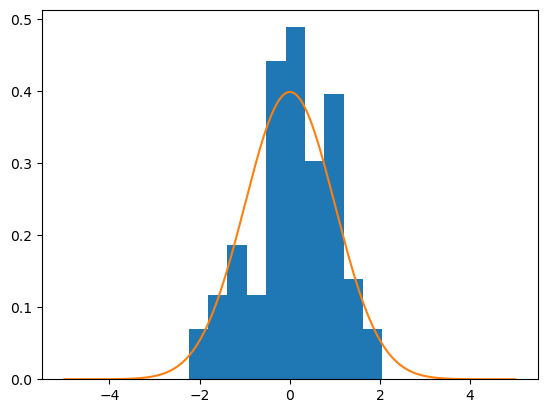

In [4]:
n = 100
true_theta, true_tau = 0,1
data_generating_mechanism = \
stats.norm(loc=true_theta, scale=true_tau**(-0.5))

x = data_generating_mechanism.rvs(size=n)
plt.hist(x, density=True)
x_grid = np.linspace(-5*true_tau**(-0.5),5*true_tau**(-0.5),1000)
plt.plot(x_grid,data_generating_mechanism.pdf(x_grid));


In [5]:
conjugate_normal_gamma = pymc.Model()

with conjugate_normal_gamma:

    # Priors for unknown model parameters
    
    theta0 = 0  # prior belief regarding true_theta
    theta_prior_n = 1  # strength of prior belief as units of data
    # theta_prior_n = tau0/true_tau
    tau0 = theta_prior_n*true_tau  
    theta = pymc.Normal("theta", mu=theta0, sigma=tau0**(-0.5))
    # Compared to scipy.stats
    # loc -> mu
    # scale -> sigma but you can also use tau as below...
    
    tau_SS_prior = 1  # prior belief regarding true_sum_of_squares
    tau_prior_n = 1  # strength of prior belief as units of data
    tau = pymc.Gamma("tau", alpha=tau_prior_n/2, 
                            beta=tau_SS_prior/2)
    # https://en.wikipedia.org/wiki/Gamma_distribution
    # pymc.Gamma?
    # Now it's **rate** (beta) NOT scale

    # Likelihood (sampling distribution) of observations
    x_obs = pymc.Normal("x_obs", mu=theta, tau=tau, observed=x)

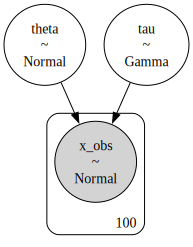

In [6]:
pymc.model_to_graphviz(conjugate_normal_gamma)

In [7]:
m = 10000
with conjugate_normal_gamma:
    # draw m posterior samples
    idata = pymc.sample(draws=m, chains=2, tune=100)
    # arviz.InferenceData object

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, tau]


Output()

Sampling 2 chains for 100 tune and 10_000 draw iterations (200 + 20_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


## `idata` and `arviz as az`

In [8]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [9]:
idata.posterior

<xarray.Dataset> Size: 400kB
Dimensions:  (chain: 2, draw: 10000)
Coordinates:
  * chain    (chain) int64 16B 0 1
  * draw     (draw) int64 80kB 0 1 2 3 4 5 6 ... 9994 9995 9996 9997 9998 9999
Data variables:
    theta    (chain, draw) float64 160kB 0.09675 0.0861 ... 0.1092 0.2107
    tau      (chain, draw) float64 160kB 1.119 1.102 1.162 ... 1.298 1.149 1.21
Attributes:
    created_at:                 2025-02-12T18:09:40.403188+00:00
    arviz_version:              0.20.0
    inference_library:          pymc
    inference_library_version:  5.20.1
    sampling_time:              1.3279528617858887
    tuning_steps:               100

In [10]:
idata.posterior['theta']

<xarray.DataArray 'theta' (chain: 2, draw: 10000)> Size: 160kB
array([[0.09675321, 0.08610405, 0.04492852, ..., 0.05800368, 0.17895928,
        0.12812897],
       [0.05024272, 0.05263978, 0.1083959 , ..., 0.09305659, 0.10922632,
        0.21069249]])
Coordinates:
  * chain    (chain) int64 16B 0 1
  * draw     (draw) int64 80kB 0 1 2 3 4 5 6 ... 9994 9995 9996 9997 9998 9999

In [11]:
idata.posterior['tau']

<xarray.DataArray 'tau' (chain: 2, draw: 10000)> Size: 160kB
array([[1.11940399, 1.10236577, 1.16225424, ..., 1.0925204 , 1.23014742,
        1.11967211],
       [0.97374728, 0.98929098, 1.19436003, ..., 1.2976246 , 1.1485401 ,
        1.21005358]])
Coordinates:
  * chain    (chain) int64 16B 0 1
  * draw     (draw) int64 80kB 0 1 2 3 4 5 6 ... 9994 9995 9996 9997 9998 9999

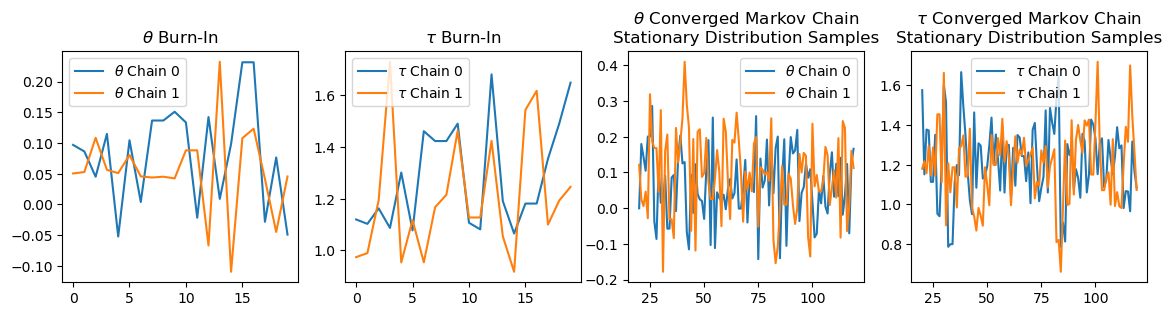

In [12]:
theta = idata.posterior['theta'].values#.shape
tau = idata.posterior['tau'].values#.shape

fig,ax = plt.subplots(1, 4, figsize=(14,3));ax[0].set_title("$\\theta$ Burn-In"); ax[1].set_title("$\\tau$ Burn-In"); ax[2].set_title("$\\theta$ Converged Markov Chain\nStationary Distribution Samples"); ax[3].set_title("$\\tau$ Converged Markov Chain\nStationary Distribution Samples")

# pymc.sample(draws=1000, chains=2, tune=100)
# used 100 samples per chain to "tune" and these were
# automatically discarded so `burn` is likely not needed
burn = 20
demo = 120
C = 2
for c in range(C):
    ax[0].plot(theta[c,:burn], label="$\\theta$ Chain "+str(c))
    ax[1].plot(tau[c,:burn], label="$\\tau$ Chain "+str(c))
    ax[2].plot(np.arange(burn, demo, dtype=int), theta[c,burn:demo], label="$\\theta$ Chain "+str(c))
    ax[3].plot(np.arange(burn, demo, dtype=int), tau[c,burn:demo], label="$\\tau$ Chain "+str(c))
ax[0].legend(); ax[1].legend(); ax[2].legend(); ax[3].legend();  

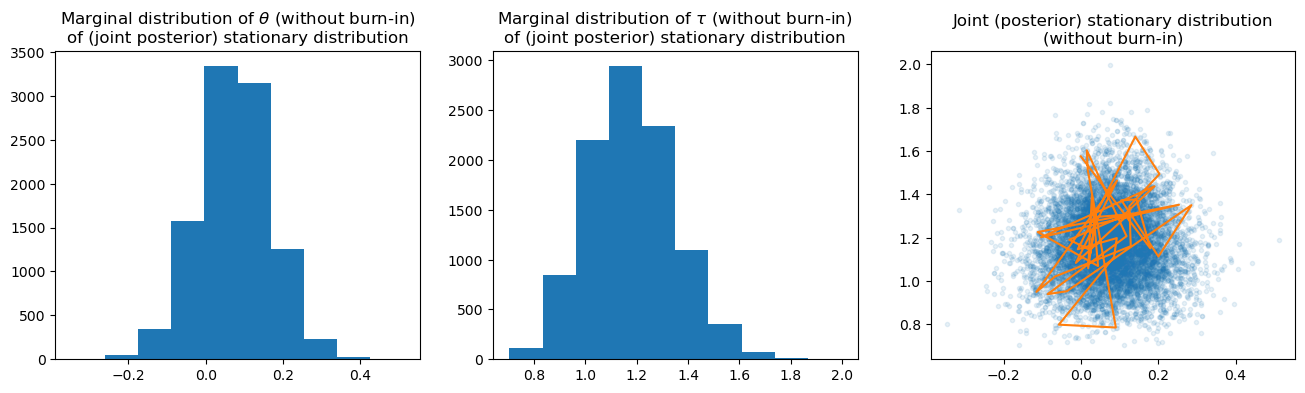

In [13]:
fig,ax = plt.subplots(1, 3, figsize=(16,4))
ax[0].set_title("Marginal distribution of $\\theta$ (without burn-in)\nof (joint posterior) stationary distribution")
ax[1].set_title("Marginal distribution of $\\tau$ (without burn-in)\nof (joint posterior) stationary distribution")
ax[2].set_title("Joint (posterior) stationary distribution\n(without burn-in)")

ax[0].hist(theta[0,burn:])
ax[1].hist(tau[0,burn:])
ax[2].plot(theta[0,burn:], tau[0,burn:], '.', alpha=0.1);
demo = 3*burn
ax[2].plot(theta[0,burn:demo], tau[0,burn:demo]);

In [14]:
import arviz as az

In [15]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

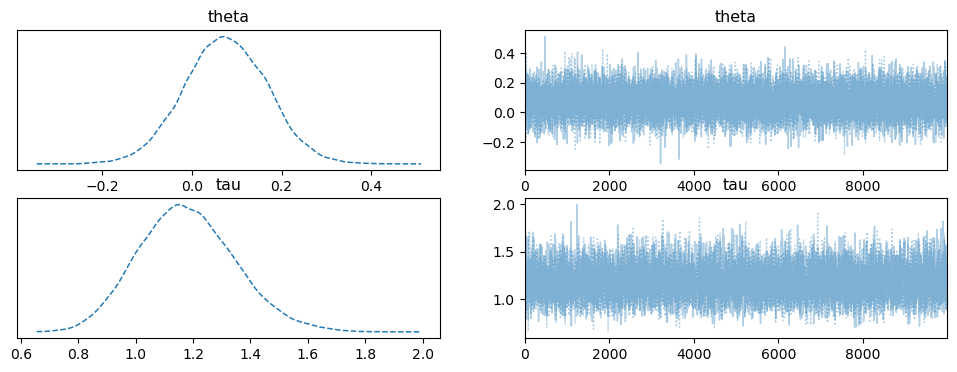

In [16]:
az.plot_trace(idata, combined=True);

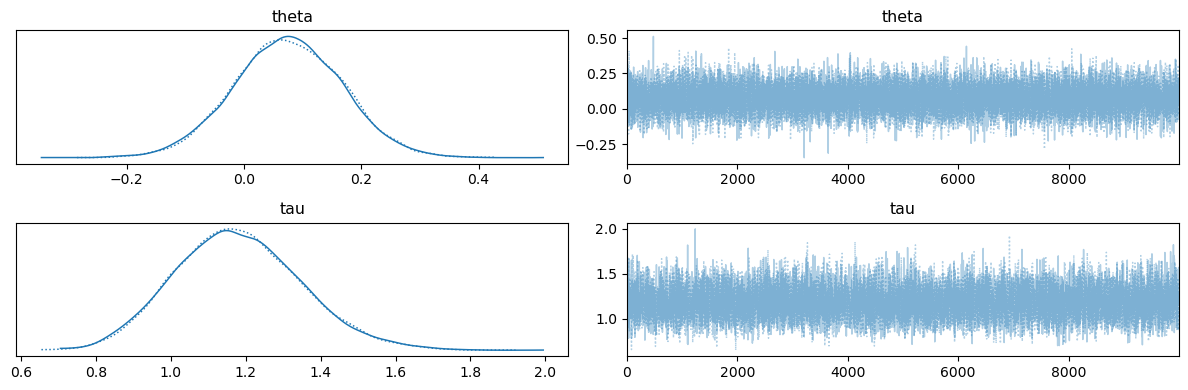

In [17]:
az.plot_trace(idata)
plt.tight_layout()

In [18]:
m = 1000
with conjugate_normal_gamma:
    # draw m posterior samples
    idata = pymc.sample(draws=m, chains=2, tune=100)
    # arviz.InferenceData object

theta = idata.posterior['theta'].values#.shape
tau = idata.posterior['tau'].values#.shape    

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, tau]


Output()

Sampling 2 chains for 100 tune and 1_000 draw iterations (200 + 2_000 draws total) took 0 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [19]:
# If the messages below don't show
"""Auto-assigning NUTS sampler...
   Initializing NUTS using jitter+adapt_diag...
   Multiprocess sampling (2 chains in 4 jobs)
   NUTS: [theta, tau] """
# You can see this information by turning on logging
import logging # dir(logging) for available functionality
_log = logging.getLogger("pymc")
#_log.setLevel(logging.NOTSET) # 0
_log.setLevel(logging.INFO) # 20
#_log.setLevel(logging.WARNING) # 30
#_log.setLevel(logging.ERROR) # 40

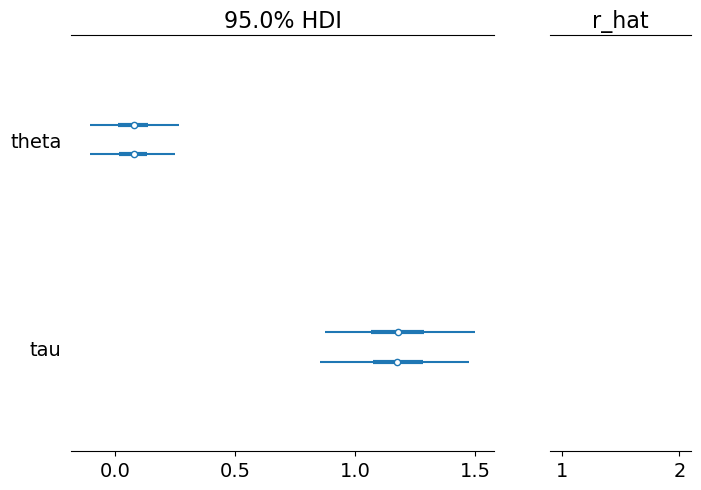

In [20]:
az.plot_forest(idata, var_names=["theta", "tau"], 
               combined=False, hdi_prob=0.95, r_hat=True);


## Part B: Posterior inference and diagnostics<br><sub>with `az.summary`</sub>

In [21]:
az.summary(idata, round_to=5)#2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.07495,0.09159,-0.10221,0.23967,0.00195,0.00165,2200.86213,1432.93877,1.00077
tau,1.18396,0.16072,0.87483,1.47472,0.00534,0.00380,916.11326,1003.35257,1.00017


In [22]:
theta.ravel().shape

(2000,)

### `mean` and `sd`

In [23]:
round_to=5
theta.ravel().mean().round(round_to), tau.ravel().mean().round(round_to)

(0.07495, 1.18396)

In [24]:
theta.ravel().std().round(round_to), tau.ravel().std().round(round_to)
theta.ravel().std(ddof=1).round(round_to), tau.ravel().std(ddof=1).round(round_to)

(0.09159, 0.16072)

### `hdi_3%` and `hdi_97%`

In [25]:
az.summary(idata, round_to=5)#2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.07495,0.09159,-0.10221,0.23967,0.00195,0.00165,2200.86213,1432.93877,1.00077
tau,1.18396,0.16072,0.87483,1.47472,0.00534,0.00380,916.11326,1003.35257,1.00017


In [26]:
np.quantile(theta,[0.05,0.95]).round(round_to)

array([-0.0791 ,  0.22319])

In [27]:
np.quantile(theta,[0.025,0.975]).round(round_to)

array([-0.10699,  0.2542 ])

In [28]:
np.quantile(theta,[0.03,0.97]).round(round_to)

array([-0.09839,  0.24778])

In [29]:
# hdi_3% and hdi_97% is something like
# move interval up or down until the smallest interval is found
np.quantile(theta,[0.02,0.96]).round(round_to)

array([-0.11633,  0.2343 ])

In [30]:
# so trying to get a bit closer for tau it's someting like
np.quantile(tau,[0.022,0.9622]).round(round_to)

array([0.88162, 1.48479])

### To consider `mcse_mean` and `mcse_sd`...

- [...moments of moments and first order Taylor series approximation](https://mc-stan.org/posterior/reference/mcse_sd.html)

In [31]:
az.summary(idata, round_to=5)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.07495,0.09159,-0.10221,0.23967,0.00195,0.00165,2200.86213,1432.93877,1.00077
tau,1.18396,0.16072,0.87483,1.47472,0.00534,0.00380,916.11326,1003.35257,1.00017


In [32]:
az.summary(idata, round_to=5)['sd']['theta']/\
az.summary(idata, round_to=5)['ess_bulk']['theta']**0.5

0.0019523228630908991

In [33]:
az.summary(idata, round_to=5)['sd']['tau']/\
(az.summary(idata, round_to=5)['ess_bulk']['tau']+0)**0.5

0.005310010001890627

In [34]:
((theta.ravel()-theta.ravel().mean())**2).var()/\
az.summary(idata, round_to=5)['ess_bulk']['theta']


6.373610935857812e-08

In [35]:
# this estimates y which is the variance
((theta.ravel()-theta.ravel().mean())**2).mean()
theta.ravel().var()
# square root of this estimates standard deviation
# s = sqrt(y)

# this estimates variance of y above estimator
((theta.ravel()-theta.ravel().mean())**2).var()/\
az.summary(idata, round_to=5)['ess_bulk']['theta']

# by the delta method 
# https://stats.stackexchange.com/questions/491845/how-is-delta-method-used-here-in-approximating-the-square-root-of-a-normal-rando
# var(S) = (1/sqrt(E[Y]))**2 * Var(Y)

((1/theta.ravel().var())*\
 ((theta.ravel()-theta.ravel().mean())**2).var()/\
 az.summary(idata, round_to=15)['ess_bulk']['theta'])**0.5

# So it's not quite right...but then again it's maybe not exactly
# https://mc-stan.org/posterior/reference/mcse_sd.html
# "Compute the Monte Carlo standard error for the 
#  standard deviation (SD) of a single variable 
#  without assuming normality using moments of moments 
#  and first order Taylor series approximation 
#  (Kenney and Keeping, 1951, p. 141)."

0.002757200834946247

In [36]:
((1/tau.ravel().var())*\
 ((tau.ravel()-tau.ravel().mean())**2).var()/\
 az.summary(idata, round_to=15)['ess_bulk']['tau'])**0.5

0.00757534552833067

In [37]:
az.summary(idata, round_to=5)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.07495,0.09159,-0.10221,0.23967,0.00195,0.00165,2200.86213,1432.93877,1.00077
tau,1.18396,0.16072,0.87483,1.47472,0.00534,0.00380,916.11326,1003.35257,1.00017


### We must first consider `bulk_tail` and `ess_tail`...

- [bulk_tail](https://mc-stan.org/posterior/reference/ess_bulk.html)
- [ess_tail](https://mc-stan.org/posterior/reference/ess_tail.html)

#### Effective sample size

$$n_{\text{eff}} = \frac{m}{\sum_{k=-\infty}^\infty\rho_k} = \frac{m}{1+2\sum_{k=1}^\infty\rho_k} \quad \text{ for order $k$ autocorrelations } \quad \rho_k $$


In [38]:
theta_in_tail = \
(theta<=np.quantile(theta.ravel(),0.05))#+\
(theta>=np.quantile(theta.ravel(),0.95))
print(theta_in_tail.sum()/(2*m))
theta_in_tail

0.05


array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

1519.1691736713597

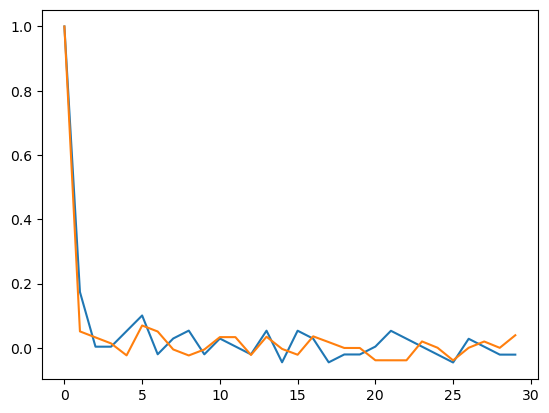

In [39]:
m = 1000
K = 30
autocorrelations = np.ones((2,int(m/2)))
for c in range(C):
    for t_plus_k in range(1, int(m/2)):
        autocorrelations[c,t_plus_k] = \
        np.corrcoef(theta_in_tail[c,:-t_plus_k], 
                    theta_in_tail[c,t_plus_k:])[0,1]

for c in range(C):
    plt.plot(autocorrelations[c,:K], label="Chain "+str(c)) 

# effective sample size
approximation_stops=[5,4]
approximation_stops,
m / (1 + 2*autocorrelations[0,1:approximation_stops[0]].sum())+\
m / (1 + 2*autocorrelations[1,1:approximation_stops[1]].sum())


In [40]:
autocorrelations[:,:10]

array([[ 1.        ,  0.17373747,  0.00357969,  0.00353469,  0.05209986,
         0.10066934, -0.02008114,  0.02903936,  0.0535799 , -0.02021908],
       [ 1.        ,  0.05112303,  0.03245894,  0.01379246, -0.02348523,
         0.06950211,  0.05083413, -0.00506073, -0.02373581, -0.00518427]])

In [41]:
tau_in_tail = \
(tau<=np.quantile(tau.ravel(),0.05))+\
(tau>=np.quantile(tau.ravel(),0.95))
print(tau_in_tail.sum()/(2*m))
tau_in_tail

0.1


array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

1280.2964021228192

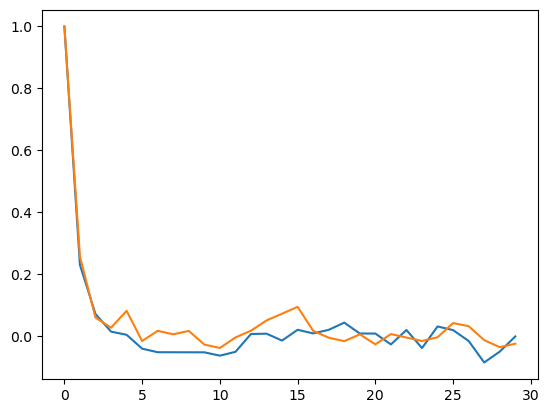

In [42]:
m = 1000
K = 30
autocorrelations = np.ones((2,m-1))
for c in range(C):
    for t_plus_k in range(1, int(m/2)):
        autocorrelations[c,t_plus_k] = \
        np.corrcoef(tau_in_tail[c,:-t_plus_k], 
                    tau_in_tail[c,t_plus_k:])[0,1]
        
for c in range(C):
    plt.plot(autocorrelations[c,:K], label="Chain "+str(c)) 

# effective sample size
approximation_stops=[8,6]
approximation_stops,
m / (1 + 2*autocorrelations[0,1:approximation_stops[0]].sum())+\
m / (1 + 2*autocorrelations[1,1:approximation_stops[1]].sum())

In [43]:
autocorrelations[:,:20]

array([[ 1.        ,  0.23065075,  0.0721542 ,  0.0154707 ,  0.0051825 ,
        -0.03947127, -0.05100896, -0.05112342, -0.05123814, -0.05135312,
        -0.06207263, -0.04982036,  0.00775411,  0.00880932, -0.01342151,
         0.02142048,  0.00966249,  0.02120792,  0.04441001,  0.00933877],
       [ 1.        ,  0.25752508,  0.0608806 ,  0.02800964,  0.08251086,
        -0.01485294,  0.01794947,  0.00686293,  0.01772425, -0.02629505,
        -0.0373912 , -0.00346758,  0.01847366,  0.05144939,  0.07340158,
         0.09535863,  0.01801913, -0.0041647 , -0.01531788,  0.00663816]])

In [44]:
az.summary(idata, round_to=5)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.07495,0.09159,-0.10221,0.23967,0.00195,0.00165,2200.86213,1432.93877,1.00077
tau,1.18396,0.16072,0.87483,1.47472,0.00534,0.00380,916.11326,1003.35257,1.00017


#### Reminder 

- [bulk_tail](https://mc-stan.org/posterior/reference/ess_bulk.html)
- [ess_tail](https://mc-stan.org/posterior/reference/ess_tail.html)

#### Effective sample size

$$n_{\text{eff}} = \frac{m}{\sum_{k=-\infty}^\infty\rho_k} = \frac{m}{1+2\sum_{k=1}^\infty\rho_k} \quad \text{ for order $k$ autocorrelations } \quad \rho_k $$


2478.180487991418

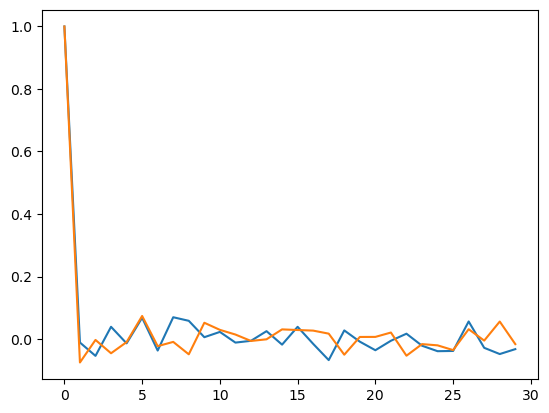

In [45]:
m = 1000
K = 30
autocorrelations = np.ones((2,int(m/2)))
for c in range(C):
    for t_plus_k in range(1, int(m/2)):
        autocorrelations[c,t_plus_k] = \
        np.corrcoef(theta[c,:-t_plus_k], 
                    theta[c,t_plus_k:])[0,1]

for c in range(C):
    plt.plot(autocorrelations[c,:K], label="Chain "+str(c)) 

# effective sample size
approximation_stops=[3,4]
approximation_stops,
m / (1 + 2*autocorrelations[0,1:approximation_stops[0]].sum())+\
m / (1 + 2*autocorrelations[1,1:approximation_stops[1]].sum())


In [46]:
autocorrelations[:,:10]

array([[ 1.        , -0.01122868, -0.05393568,  0.0390593 , -0.01388222,
         0.06803616, -0.03689059,  0.06966752,  0.05824256,  0.00582471],
       [ 1.        , -0.07506841, -0.00294486, -0.04557161, -0.00992661,
         0.07372627, -0.02281344, -0.00921872, -0.04893355,  0.05201631]])

973.2467634062054

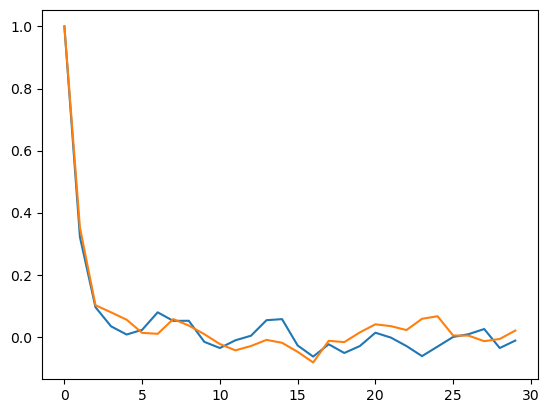

In [47]:
m = 1000
K = 30
autocorrelations = np.ones((2,int(m/2)))
for c in range(C):
    for t_plus_k in range(1, int(m/2)):
        autocorrelations[c,t_plus_k] = \
        np.corrcoef(tau[c,:-t_plus_k], 
                    tau[c,t_plus_k:])[0,1]

for c in range(C):
    plt.plot(autocorrelations[c,:K], label="Chain "+str(c)) 

# effective sample size
approximation_stops=[5,7]
approximation_stops,
m / (1 + 2*autocorrelations[0,1:approximation_stops[0]].sum())+\
m / (1 + 2*autocorrelations[1,1:approximation_stops[1]].sum())


In [48]:
autocorrelations[:,:10]

array([[ 1.        ,  0.32124522,  0.095124  ,  0.03363589,  0.0071829 ,
         0.0223181 ,  0.07868765,  0.0512042 ,  0.05147422, -0.01644329],
       [ 1.        ,  0.35156698,  0.10161708,  0.07873038,  0.05502513,
         0.01260531,  0.00938941,  0.05691564,  0.03615064,  0.00826016]])

In [49]:
az.summary(idata, round_to=5)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.07495,0.09159,-0.10221,0.23967,0.00195,0.00165,2200.86213,1432.93877,1.00077
tau,1.18396,0.16072,0.87483,1.47472,0.00534,0.00380,916.11326,1003.35257,1.00017


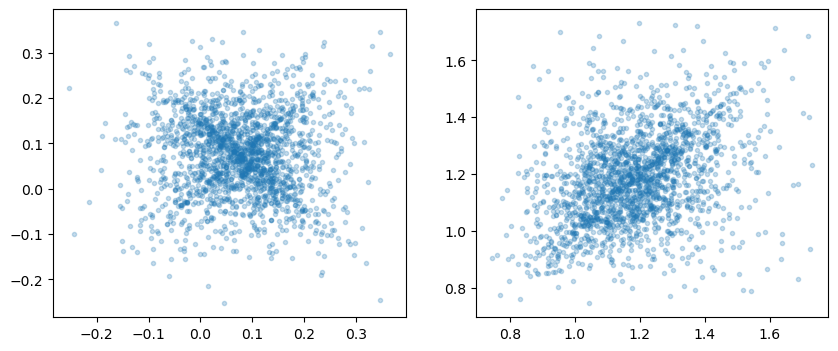

In [50]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(theta.ravel()[:-1], theta.ravel()[1:], '.', alpha=0.25)
ax[1].plot(tau.ravel()[:-1], tau.ravel()[1:], '.', alpha=0.25);

## Part C: R-hat and "energy"

A lack of insufficient "mixing" (agreement) between chains is diagnosed by comparing within and between chain variability. This is done by **checking if the split-$\hat R$ statistic is greater than** $\mathbf{1.05}$. is deemed sufficient when . This is suggestive (but not proof) that the the **Markov chains** have converged to their **stationary distributions**.

> Thus far above we have avoided the notion of "split" chains. Split chains must be considered to ensure that a "drifting chain" does not accidentally pass the $\hat R$ check. Thus the split-$\hat R$ statistic.


$\Large \text{Split-}\hat R  = \sqrt{\frac{\frac{N-1}{N}W +  \overbrace{\frac{1}{M-1}\sum_{m=1}^M (\overline{\theta^{(m,\cdot)}} - \overline{\theta^{(\cdot,\cdot)}})^2}^{\text{between chain variance}} }{\underbrace{\frac{1}{M}\sum_{m=1}^M \frac{1}{N-1}\sum_{n=1}^N (\theta^{(m,n)} - \overline{\theta^{(m,\cdot)}})^2}_{\text{$W$: within chain variance}}} } $ 

In [51]:
az.summary(idata, round_to=5)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.07495,0.09159,-0.10221,0.23967,0.00195,0.00165,2200.86213,1432.93877,1.00077
tau,1.18396,0.16072,0.87483,1.47472,0.00534,0.00380,916.11326,1003.35257,1.00017


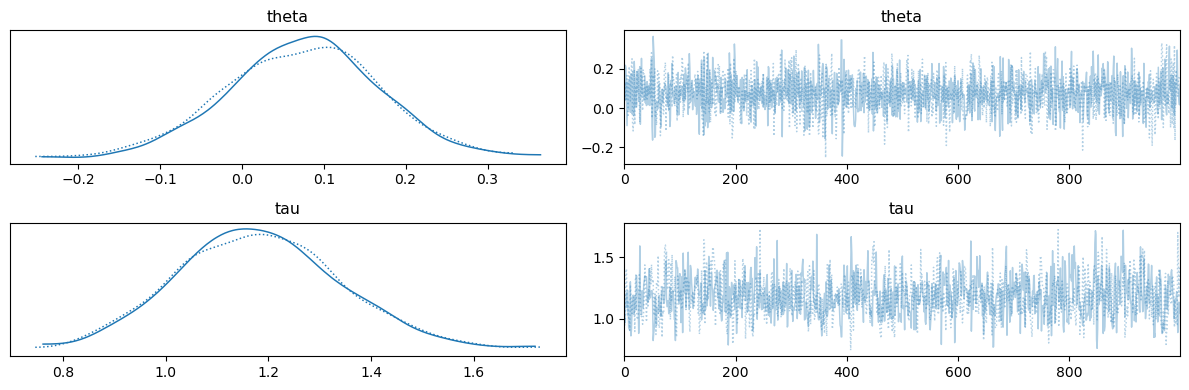

In [52]:
az.plot_trace(idata)
plt.tight_layout()

### Energy

Another diagnostic that sometimes applies is based on the so-called [energy](https://discourse.mc-stan.org/t/help-understanding-bfmi-interpreting-bfmi-1/28554). The exact meaning of "energy" will be discussed next class but for now suffice it to say that when the "Energy transition" fails to dominate the "Marginal energy" the sampler is experiencing a computational bottleneck.


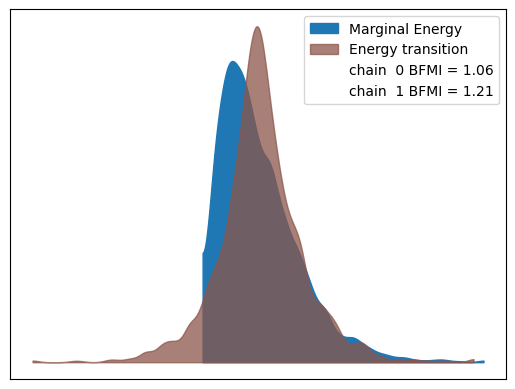

In [53]:
az.plot_energy(idata);

## Part D: Samplers


In [54]:
pymc.sample

<function pymc.sampling.mcmc.sample(draws: int = 1000, *, tune: int = 1000, chains: int | None = None, cores: int | None = None, random_seed: None | int | collections.abc.Sequence[int] | numpy.ndarray | numpy.random.mtrand.RandomState | numpy.random._generator.Generator = None, progressbar: Union[bool, Literal['combined', 'split', 'combined+stats', 'stats+combined', 'split+stats', 'stats+split']] = True, progressbar_theme: rich.theme.Theme | None = None, step=None, var_names: collections.abc.Sequence[str] | None = None, nuts_sampler: Literal['pymc', 'nutpie', 'numpyro', 'blackjax'] = 'pymc', initvals: dict[pytensor.graph.basic.Variable | str, numpy.ndarray | pytensor.graph.basic.Variable | str] | collections.abc.Sequence[dict[pytensor.graph.basic.Variable | str, numpy.ndarray | pytensor.graph.basic.Variable | str] | None] | None = None, init: str = 'auto', jitter_max_retries: int = 10, n_init: int = 200000, trace: pymc.backends.base.BaseTrace | None = None, discard_tuned_samples: bool 

Multiprocess sampling (4 chains in 4 jobs)
HamiltonianMC: [theta, tau]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.07,0.09,-0.10,0.26,0.0,0.0,2278.41,2451.12,1.0
tau,1.19,0.17,0.89,1.52,0.0,0.0,2085.16,2251.82,1.0


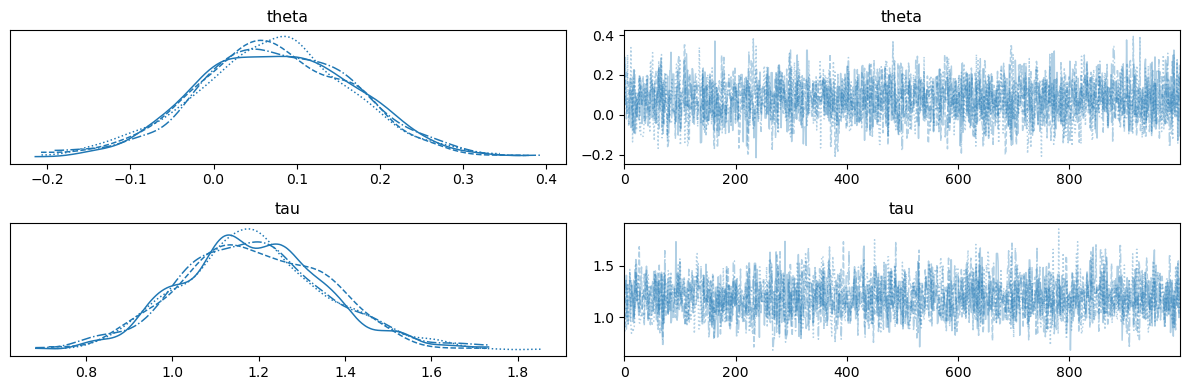

In [55]:
with conjugate_normal_gamma:
    HMC = pymc.HamiltonianMC()
    idata_HMC = pymc.sample(chains=4, step=HMC)
    
display(az.summary(idata_HMC, round_to=2))
az.plot_trace(idata_HMC)
plt.tight_layout()    

In [56]:
# theta rejection rates
(idata_HMC.posterior.theta.values[:,:-1]==idata_HMC.posterior.theta.values[:,1:]).mean(axis=1)

array([0.30530531, 0.30830831, 0.2972973 , 0.25525526])

In [57]:
# tau rejection rates
(idata_HMC.posterior.tau.values[:,:-1]==idata_HMC.posterior.tau.values[:,1:]).mean(axis=1)

array([0.30530531, 0.30830831, 0.2972973 , 0.25525526])

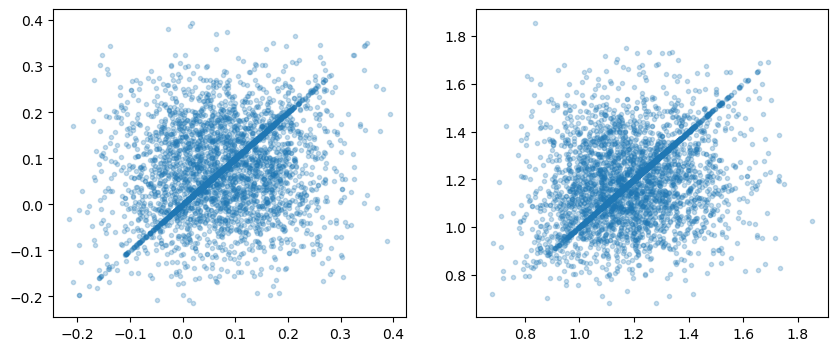

In [58]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(idata_HMC.posterior.theta.values.ravel()[:-1], 
           idata_HMC.posterior.theta.values.ravel()[1:], '.', alpha=0.25)
ax[1].plot(idata_HMC.posterior.tau.values.ravel()[:-1], 
           idata_HMC.posterior.tau.values.ravel()[1:], '.', alpha=0.25);

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, tau]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.07,0.09,-0.10,0.24,0.0,0.0,3574.31,2529.29,1.0
tau,1.18,0.17,0.87,1.50,0.0,0.0,3647.36,2498.15,1.0


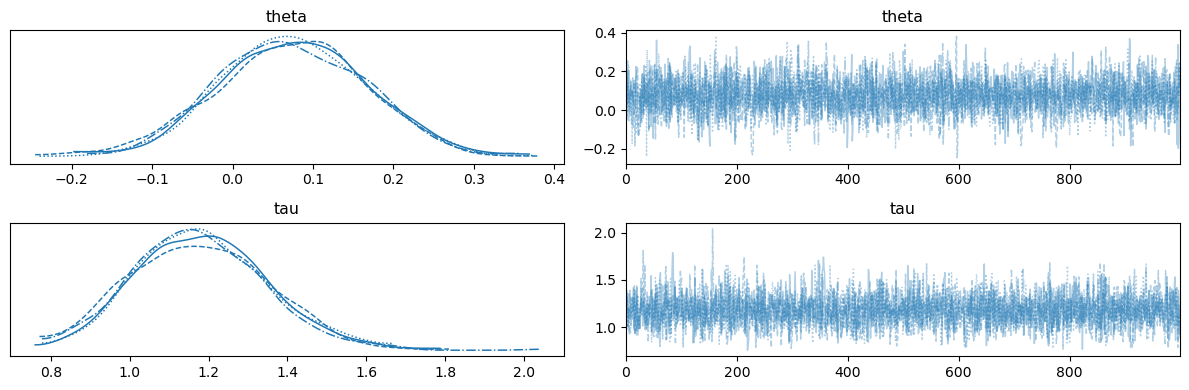

In [59]:
with conjugate_normal_gamma:
    idata = pymc.sample(chains=4, target_accept=0.9)
    
display(az.summary(idata, round_to=2))
az.plot_trace(idata)
plt.tight_layout()    

In [60]:
import pandas as pd
display(pd.DataFrame(idata.sample_stats.acceptance_rate))
# rejection rates
1-idata.sample_stats.acceptance_rate.values.mean(axis=1)

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,0.999966,0.883694,0.912691,1.000000,0.982943,0.581650,0.980019,0.856356,0.912559,...,0.921032,0.922227,0.934971,0.761042,0.856258,1.000000,0.868083,1.000000,1.000000,0.876714
1,1.000000,0.994474,0.941283,0.964726,1.000000,0.972918,0.736883,1.000000,0.965357,0.991613,...,0.975921,0.844738,0.757441,0.841130,0.935003,0.737152,1.000000,1.000000,0.846456,1.000000
2,0.879328,0.975808,0.766408,0.969031,0.973245,0.866914,0.905587,0.859713,0.854125,0.929357,...,0.917412,0.578984,0.976292,0.908291,0.929094,0.653067,1.000000,0.955912,0.837153,1.000000
3,0.906955,0.844040,0.877862,0.560074,1.000000,0.941980,0.989414,0.981301,1.000000,0.927914,...,1.000000,1.000000,0.981411,0.932864,0.849186,0.975692,0.801897,0.877155,0.846811,0.868991


array([0.10103175, 0.0986532 , 0.10838408, 0.09148045])

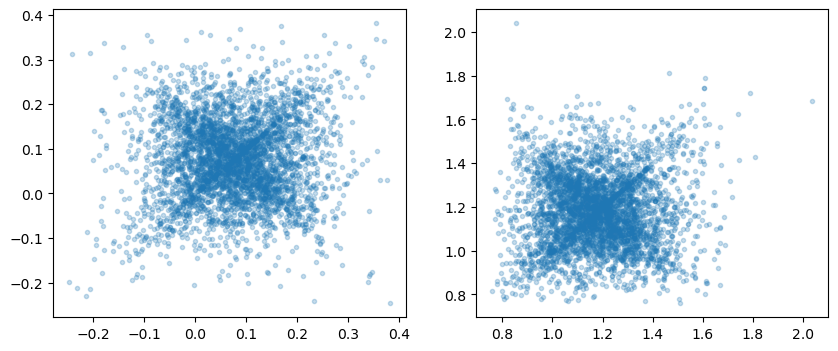

In [61]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(idata.posterior.theta.values.ravel()[:-1], 
           idata.posterior.theta.values.ravel()[1:], '.', alpha=0.25)
ax[1].plot(idata.posterior.tau.values.ravel()[:-1], 
           idata.posterior.tau.values.ravel()[1:], '.', alpha=0.25);

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [theta]
>Slice: [tau]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.08,0.09,-0.09,0.25,0.0,0.0,3794.04,2900.61,1.0
tau,1.18,0.17,0.88,1.50,0.0,0.0,3549.07,2156.08,1.0


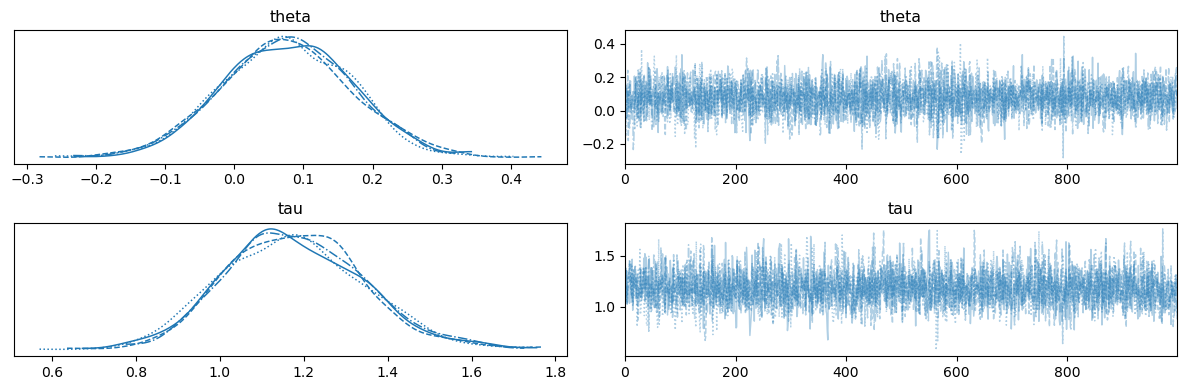

In [62]:
with conjugate_normal_gamma:
    sampler = pymc.Slice()
    idata_slice = pymc.sample(step=sampler)

display(az.summary(idata_slice, round_to=2))
az.plot_trace(idata_slice)
plt.tight_layout()    

In [63]:
# theta rejection rates
(idata_slice.posterior.theta.values[:,:-1]==idata_slice.posterior.theta.values[:,1:]).mean(axis=1)

array([0., 0., 0., 0.])

In [64]:
# tau rejection rates
(idata_slice.posterior.tau.values[:,:-1]==idata_slice.posterior.tau.values[:,1:]).mean(axis=1)

array([0., 0., 0., 0.])

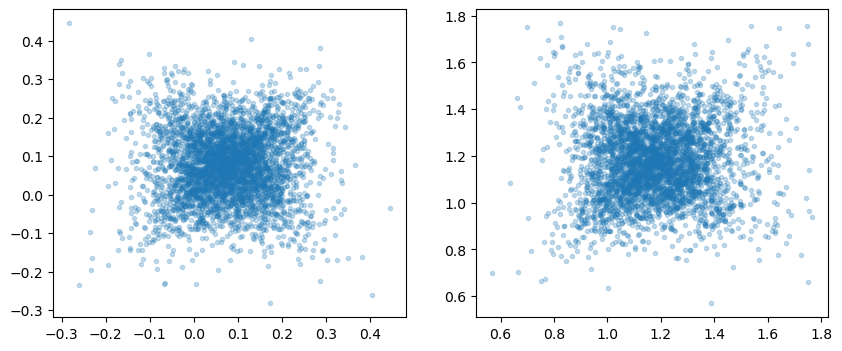

In [65]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(idata_slice.posterior.theta.values.ravel()[:-1], 
           idata_slice.posterior.theta.values.ravel()[1:], '.', alpha=0.25)
ax[1].plot(idata_slice.posterior.tau.values.ravel()[:-1], 
           idata_slice.posterior.tau.values.ravel()[1:], '.', alpha=0.25);

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [theta]
>Metropolis: [tau]


Output()

Sampling 4 chains for 0 tune and 1_000 draw iterations (0 + 4_000 draws total) took 0 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.07,0.09,-0.11,0.24,0.01,0.00,273.67,255.96,1.01
tau,1.17,0.17,0.86,1.48,0.01,0.01,435.99,427.42,1.02


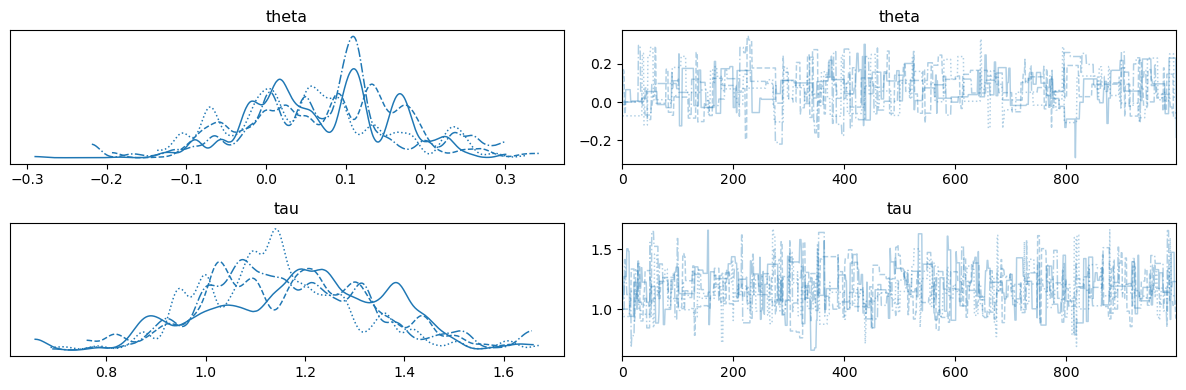

In [66]:
with conjugate_normal_gamma:
    MHv1 = pymc.Metropolis(S=np.ones(1), scaling=1, tune=False)
    idata_MHv1 = pymc.sample(draws=1000, tune=0, chains=4, step=MHv1)

display(az.summary(idata_MHv1, round_to=2))
az.plot_trace(idata_MHv1)
plt.tight_layout()    

In [67]:
# theta rejection rates
(idata_MHv1.posterior.theta.values[:,:-1]==idata_MHv1.posterior.theta.values[:,1:]).mean(axis=1)

array([0.87587588, 0.8968969 , 0.87687688, 0.89189189])

In [68]:
# tau rejection rates
(idata_MHv1.posterior.tau.values[:,:-1]==idata_MHv1.posterior.tau.values[:,1:]).mean(axis=1)

array([0.81181181, 0.84084084, 0.81381381, 0.82782783])

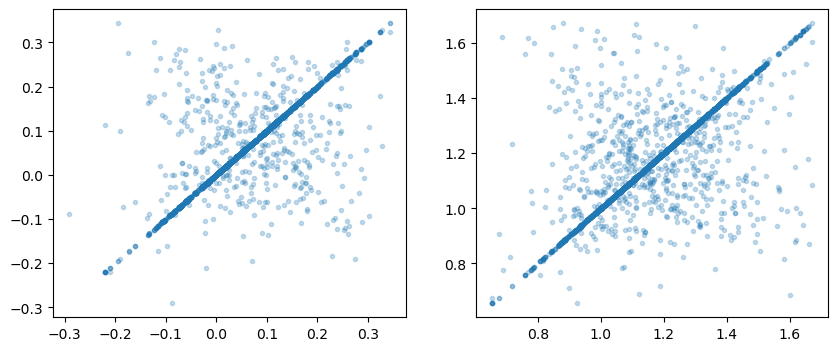

In [69]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(idata_MHv1.posterior.theta.values.ravel()[:-1], 
           idata_MHv1.posterior.theta.values.ravel()[1:], '.', alpha=0.25)
ax[1].plot(idata_MHv1.posterior.tau.values.ravel()[:-1], 
           idata_MHv1.posterior.tau.values.ravel()[1:], '.', alpha=0.25);

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [theta]
>Metropolis: [tau]


Output()

Sampling 4 chains for 0 tune and 1_000 draw iterations (0 + 4_000 draws total) took 0 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.08,0.09,-0.09,0.25,0.00,0.00,630.88,905.99,1.01
tau,1.19,0.16,0.91,1.47,0.01,0.01,370.31,522.16,1.01


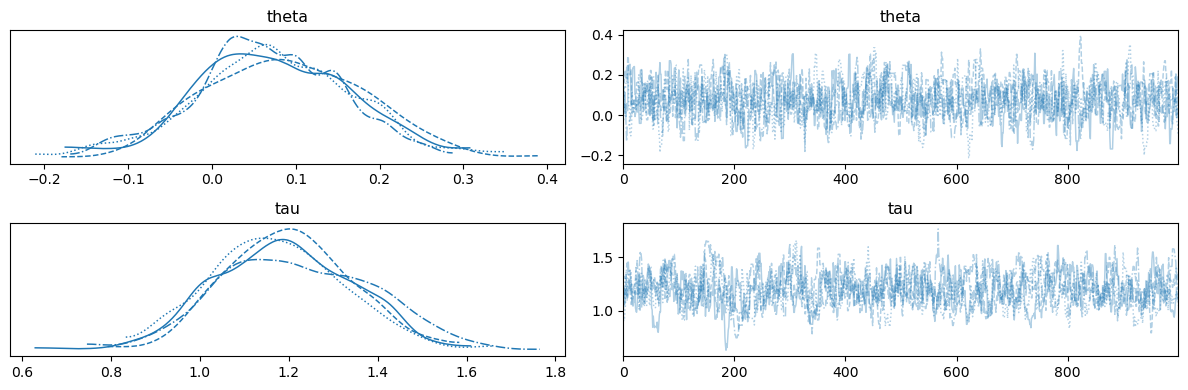

In [70]:
with conjugate_normal_gamma:
    MHv2 = pymc.Metropolis(S=np.ones(1), scaling=0.1, tune=False)
    idata_MHv2 = pymc.sample(draws=1000, tune=0, chains=4, step=MHv2)

display(az.summary(idata_MHv2, round_to=2))
az.plot_trace(idata_MHv2)
plt.tight_layout()    

In [71]:
# theta rejection rates
(idata_MHv2.posterior.theta.values[:,:-1]==idata_MHv2.posterior.theta.values[:,1:]).mean(axis=1)

array([0.30730731, 0.2982983 , 0.31131131, 0.34034034])

In [72]:
# tau rejection rates
(idata_MHv2.posterior.tau.values[:,:-1]==idata_MHv2.posterior.tau.values[:,1:]).mean(axis=1)

array([0.18618619, 0.1961962 , 0.19319319, 0.23023023])

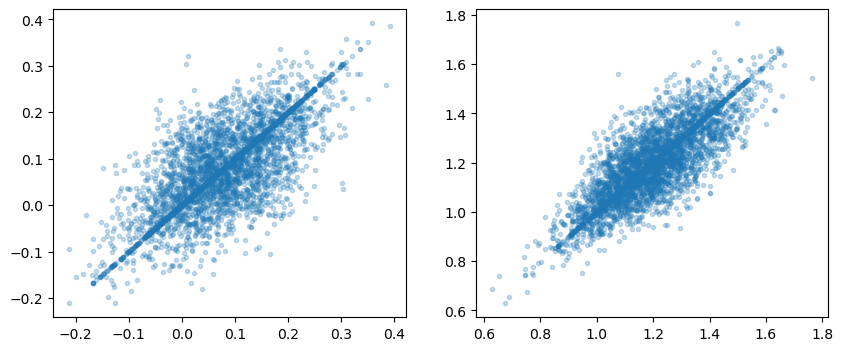

In [73]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(idata_MHv2.posterior.theta.values.ravel()[:-1], 
           idata_MHv2.posterior.theta.values.ravel()[1:], '.', alpha=0.25)
ax[1].plot(idata_MHv2.posterior.tau.values.ravel()[:-1], 
           idata_MHv2.posterior.tau.values.ravel()[1:], '.', alpha=0.25);

## Week 5 Homework

---

### Q1: Questions about PyMC...

Complete this formatted markdown listing of the contents of "PyMC Example Gallery". *Include links and your favorite image (right click and "copy image address") from each page.*


#### Introductory

- [General Overview](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html)
- [Simple Linear Regression](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/GLM_linear.html)
- [General API quickstart](https://www.pymc.io/projects/examples/en/latest/introductory/api_quickstart.html)

| | | |
|-|-|-|
|![](https://www.pymc.io/projects/docs/en/stable/_images/ac30f30b2297ec4f2bb798b4f28d2cbba2d0502dbaae4a5f78fdd5cccacda517.svg)|<img src="https://www.pymc.io/projects/docs/en/stable/_images/a8276d1222c43c061dbfff6fa3ff3af15b86038fd7d1e204c429ae3714ea1a20.png"  width="500"/>|![](https://www.pymc.io/projects/examples/en/latest/_images/434538d8660bf2399ebf9df11cbd2b7cec62d8abafc588da625315074b628118.png)|

#### Library Fundamentals

- Distribution Dimensionality
- PyMC and PyTensor
- Using Data Containers

| | | |
|-|-|-|
|1|2|3|


#### Etc.

- 1.
- 2.
- 3.
- 4.
- 5.
- 6.
- 7.
- 8.
- 9.
- 10.
- 11.
- 12.
- 13.


| | | | |
|-|-|-|-|
|1|2|3|4|
|5|6|7|8|
|9|10|11|12|

Etc.


### Q2: Continue "Q2" of the previous weeks 3 and 4

1. *Use PyMC to provide Bayesian inference for the paramaters associated with a sample of normal data where your prior for theta is a normal distribution and your prior for $\tau$ is a gamma distribution. Provide diagnostic assessments of the performance of your algorithm.*

2. *Use PyMC to provide Bayesian inference for the paramaters associated with a sample of normal data where your prior for theta is a non normal distribution and your prior for $\tau$ is a non-gamma distribution. Provide diagnostic assessments of the performance of your algorithm.*

3. *Use PyMC to provide Bayesian inference for the paramaters associated with a sample of normal data where your prior for theta is a yet another different again non normal distribution and your prior for $\tau$ is a yet another different again non-gamma distribution. Provide diagnostic assessments of the performance of your algorithm.*

### Q3: Slice Sampling

*First explain how the Markov algorithm of slice sampling as given below works. Then explain the steps by which slice sampling could be used in place of a Metropolis-Hasting step in a Metropolis within Gibbs algorithm where the full conditionals are only known up to a normalizing constant. In your explanation clarify what the curve that we're sampling beneath is, and what the initial value and steps are to create the draw for Gibbs sampling.*

In [74]:
def slice_f_at_y(f, x, y, x_grid=np.linspace(0,1,51)):
    
    # find interval of grid points where f(x_grid) > y 
    # then extend the enterval so endpoints f(a)<y and f(b)<y 
    x_grid_delta = x_grid[1]-x_grid[0]
    a,b = x_grid[f(x_grid)>y][[0,-1]]+[-x_grid_delta,x_grid_delta]
    # a,b = x_grid[0,-1]  # make the interval all of x_grid
    
    x_ = a + stats.uniform().rvs()*(b-a)    
    if f(x_)>y:
        return x_,1  # in 1 try if f(x_)>y and "x_ is under f" 
    elif x_ < x:  # or if "x_ was above f on the left side of the interval" 
        x_l,x_r = x_,b
    else:
        x_l,x_r = a,x_  # or if "x_ was above f on the right side of the interval"
    return slice_f_at_y_(f, x, y, x_l, x_r, tot = 2)  # try again with a reduced interval

def slice_f_at_y_(f, x, y, x_l=0, x_r=1, tot=1):
    
    x_ = x_l + stats.uniform().rvs()*(x_r-x_l)
    
    if f(x_)>y:
        return x_,tot
    elif x_ < x:
        x_l = x_
    else:
        x_r = x_
    return slice_f_at_y_(f, x, y, x_l, x_r, tot = tot+1)


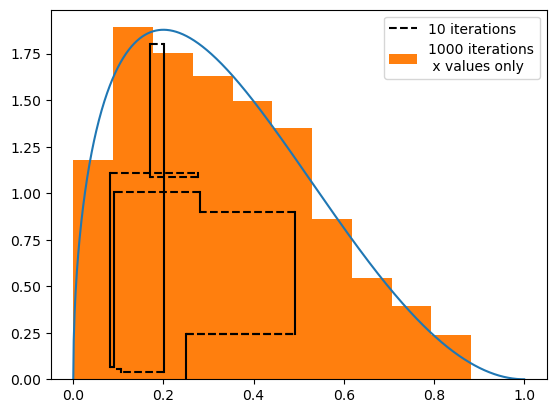

In [75]:
x_grid = np.linspace(0,1,1000)
f = lambda x: stats.beta(1.5,3).pdf(x)
plt.plot(x_grid, f(x_grid))
    
m = 1000
x = np.zeros([m+1,3])
x[:2,0] = 0.25

plot_trace = 10
for t in range(1,m):
    
    x[t,1] = stats.uniform().rvs()*f(x[t,0])
    if t < plot_trace:
        plt.plot([x[t,0]]*2, [x[t-1,1],x[t,1]], 'k')
    
    x[t+1,0],x[t+1,2] = slice_f_at_y(f, x[t,0], x[t,1])
    if t < plot_trace:
        if t==1:
            plt.plot([x[t,0], x[t+1,0]], [x[t,1]]*2, 'k--', label=str(plot_trace)+ " iterations")
        plt.plot([x[t,0], x[t+1,0]], [x[t,1]]*2, 'k--')
    
plt.hist(x[:,0], density=True, label=str(m)+" iterations\n x values only")
plt.legend();